In [1]:
%matplotlib inline
from google.cloud import bigquery
from google.oauth2 import service_account
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
credentials = service_account.Credentials.from_service_account_file(
'../../secrets/gcp_token.json')

In [3]:
client = bigquery.Client("wagon-bootcamp-428814", credentials)

In [4]:
# only get 2024 data

query = client.query("""SELECT *
                        FROM chicago_crime.chicago_crime_tab
                        WHERE EXTRACT(YEAR FROM Date) > 2010
                        AND `Community Area` = '25'
                        """)

In [5]:
df_test = query.to_dataframe()
df_test['Date'] = pd.to_datetime(df_test['Date'])

In [6]:
df_ts = df_test.set_index('Date').rename(columns = {"ID": "crimes"}).resample('W').count().crimes

<AxesSubplot:xlabel='Date'>

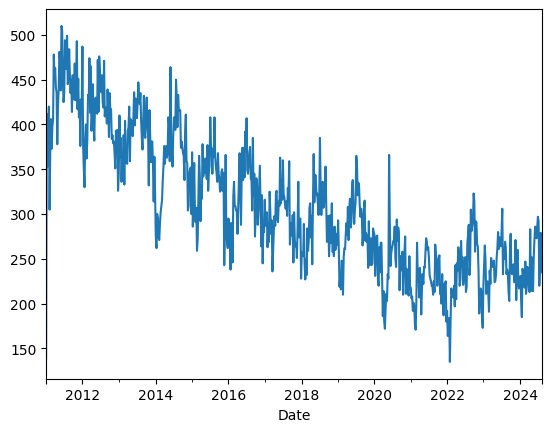

In [7]:
df_ts.plot()

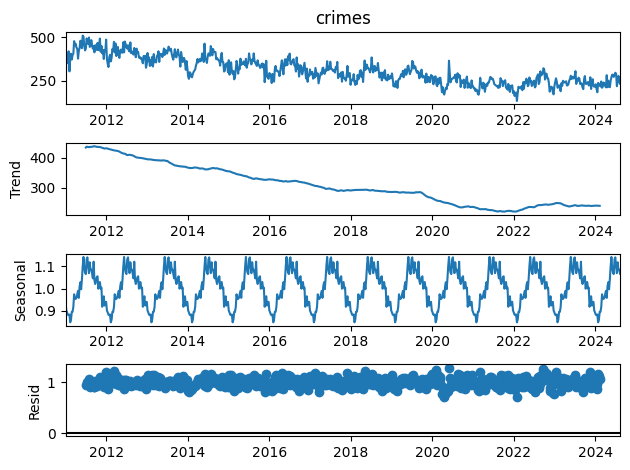

In [8]:
# now we deseasonalize
from statsmodels.tsa.seasonal import seasonal_decompose

decom_res = seasonal_decompose(df_ts, model = 'multiplicative')
seasonal = decom_res.seasonal
ts_deseasoned = df_ts/seasonal
decom_res.plot();

The time difference between the two minimums is 364 days 00:00:00


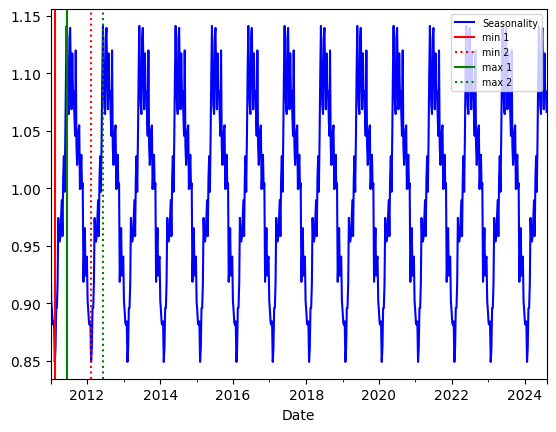

In [9]:
ax = seasonal.plot(label='Seasonality', color='blue')
min_ = seasonal.idxmin()
max_ = seasonal.idxmax()
min_2 = seasonal[max_:].idxmin()
max_2 = seasonal[min_2:].idxmax()
ax.axvline(min_,label='min 1',c='red')
ax.axvline(min_2,label='min 2',c='red', ls=':')
ax.axvline(max_,label='max 1',c='green')
ax.axvline(max_2,label='max 2',c='green', ls=':')
plt.legend(loc='upper right', fontsize='x-small')
print(f'The time difference between the two minimums is {min_2-min_}')

<AxesSubplot:xlabel='Date'>

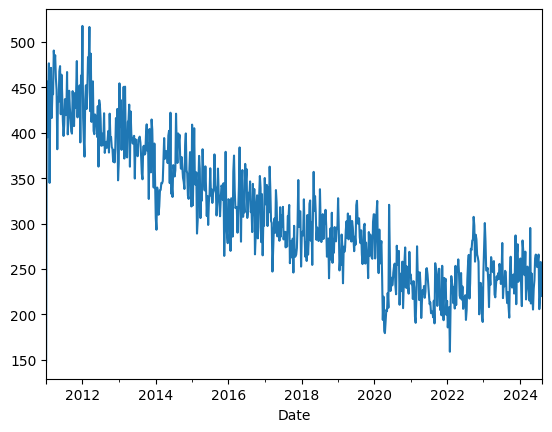

In [10]:
ts_deseasoned.plot()

In [11]:
# do differencing

ts_differenced = ts_deseasoned.diff().dropna()

In [12]:
from statsmodels.tsa.stattools import adfuller

adfuller(ts_differenced)[1]  # p-value

1.810991530276876e-15

<AxesSubplot:xlabel='Date'>

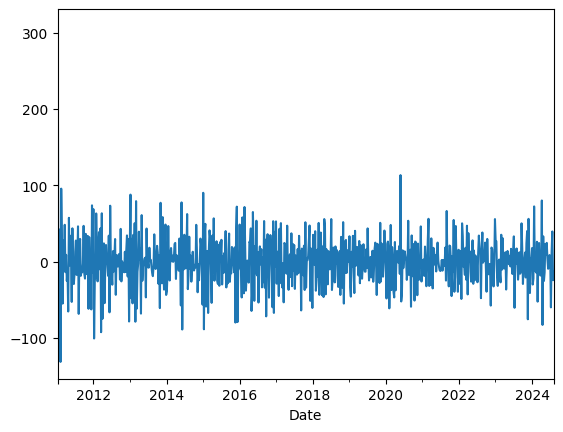

In [13]:
ts_differenced.plot()

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

/home/jonahfoong/.pyenv/versions/chicago_crimes/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


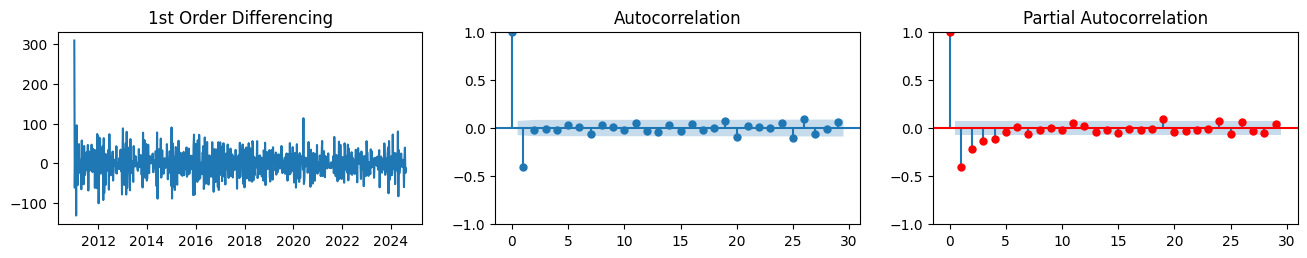

In [15]:
# ACF / PACF analysis of y_diff linearized
fig, axes = plt.subplots(1,3, figsize=(16,2.5))
axes[0].plot(ts_differenced); axes[0].set_title('1st Order Differencing')
plot_acf(ts_differenced, ax=axes[1]);
plot_pacf(ts_differenced, ax=axes[2], c='r');

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
train, test = train_test_split(df_ts, test_size = 0.2, shuffle = False)

In [19]:
import pmdarima as pm

In [ ]:

model = pm.auto_arima(
    train,
    start_p=0, max_p=2,
    start_q=0, max_q=2,
    start_P=0, max_P=2,
    start_Q=0, max_Q=2,
    d=None,           # let model determine 'd'
    test='adf',       # using adf test to find optimal 'd'
    trace=True,
    error_action='ignore',  
    suppress_warnings=True,
    seasonal=True,
    m = 52 # seasonal component
)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=6488.275, Time=0.13 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=5660.720, Time=10.25 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=5996.177, Time=11.68 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=8220.686, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=5665.161, Time=0.23 sec
 ARIMA(1,0,0)(2,0,0)[52] intercept   : AIC=5658.870, Time=112.08 sec


In [19]:
model.summary()

NameError: name 'model' is not defined

In [314]:
# get error

np.mean(abs(model.predict(len(test)) - test))

46.435200412122896

In [315]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [316]:
Final_model = SARIMAX(train.astype('int'),
                    order=model.order,
                    seasonal_order=model.seasonal_order,
                    enforce_invertibility=True,
                    enforce_stationarity=True)
Final_output = Final_model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.86909D+00    |proj g|=  2.57387D-02

At iterate    5    f=  4.86750D+00    |proj g|=  1.74895D-02

At iterate   10    f=  4.86407D+00    |proj g|=  3.41482D-03

At iterate   15    f=  4.86405D+00    |proj g|=  1.55967D-03


 This problem is unconstrained.



At iterate   20    f=  4.86398D+00    |proj g|=  2.18457D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     28      1     0     0   4.623D-05   4.864D+00
  F =   4.8639735313445946     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [317]:
# what is MAE

np.mean(abs(forecast.predicted_mean - test))

40.728816286854155

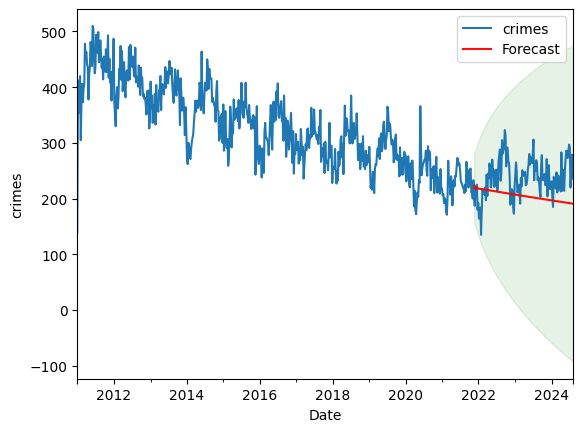

In [318]:
# Getting the forecast for 16 months
forecast = Final_output.get_forecast(steps = len(test))
forecast_conf = forecast.conf_int()
# Plot observed values
ax = df_ts.plot()
# Plot forecasted values
forecast.predicted_mean.plot(ax=ax, label='Forecast', color='red', alpha=0.95)
# Plot the range for confidence intervals
ax.fill_between(forecast_conf.index,
                forecast_conf.iloc[:, 0],
                forecast_conf.iloc[:, 1], color='g', alpha=0.1)
# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('crimes')
plt.legend()
plt.show()